# Load **Data**

In [ ]:
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset paths


# Posture dataset
posture_train_path = "/content/drive/My Drive/Computer vision project datasets/posture_correction_v4/train"


# Function to load posture data
def load_posture_data(folder_path, img_size=(224, 224)):
    classes = ["looks good", "sit up straight", "straighten head"]
    images = []
    labels = []

    for class_index, class_name in enumerate(classes):
        class_folder = os.path.join(folder_path, class_name)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            if os.path.exists(img_path):
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(class_index)  # Numeric label for the posture

    return np.array(images), np.array(labels)

# Load the posture training data
posture_images, posture_labels = load_posture_data(posture_train_path)

print("Posture Dataset:")
print("Images shape:", posture_images.shape)
print("Labels shape:", posture_labels.shape)



MessageError: Error: credential propagation was unsuccessful

# **CNN**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

class PostureCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),  # Output: 32x224x224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32x112x112

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # Output: 64x112x112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64x56x56

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  # Output: 128x56x56
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 128x28x28

            nn.Flatten(),  # Flatten for fully connected layers
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 3)  # Output layer for 3 posture classes
        )

    def forward(self, x):
        return self.network(x)

# Initialize model, loss function, and optimizer
posture_model = PostureCNN()
optimizer = optim.Adam(posture_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # For multi-class classification

# Print model summary
device = torch.device("cpu")  # Use 'cuda' if you have a GPU
posture_model.to(device)
summary(posture_model, input_size=(3, 224, 224))  # Input size is 3x224x224 (RGB image)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
          Flatten-10               [-1, 100352]               0
           Linear-11                  [-1, 256]      25,690,368
             ReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                   

# Fit **Model**

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assuming posture_images_train and posture_images_val are numpy arrays with shape (N, 224, 224, 3)
# Convert the data into torch tensors
posture_images_train = torch.tensor(posture_images_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Change to (batch, channels, height, width)
posture_images_val = torch.tensor(posture_images_val, dtype=torch.float32).permute(0, 3, 1, 2)

# Convert labels to torch tensors
posture_labels_train = torch.tensor(posture_labels_train, dtype=torch.float32)
posture_labels_val = torch.tensor(posture_labels_val, dtype=torch.float32)

# Create DataLoader for train and validation sets
train_dataset = TensorDataset(posture_images_train, posture_labels_train)
val_dataset = TensorDataset(posture_images_val, posture_labels_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model
posture_model = PostureCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss expects integer class labels
optimizer = optim.Adam(posture_model.parameters(), lr=0.001)

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))  # Use argmax for class labels
            loss.backward()
            optimizer.step()

            # Update loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():  # No gradients needed for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, torch.argmax(labels, dim=1))
                val_loss += loss.item()

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Train the model
train_model(posture_model, train_loader, val_loader, criterion, optimizer, num_epochs=5)


Epoch [1/5], Loss: 5.2945, Accuracy: 68.45%
Validation Loss: 0.4429, Validation Accuracy: 81.72%
Epoch [2/5], Loss: 0.3444, Accuracy: 86.36%
Validation Loss: 0.4438, Validation Accuracy: 85.35%
Epoch [3/5], Loss: 0.2751, Accuracy: 88.97%
Validation Loss: 0.4152, Validation Accuracy: 86.25%
Epoch [4/5], Loss: 0.2299, Accuracy: 90.74%
Validation Loss: 0.3644, Validation Accuracy: 87.61%
Epoch [5/5], Loss: 0.1947, Accuracy: 92.56%
Validation Loss: 0.3690, Validation Accuracy: 87.16%


# **make predictions**

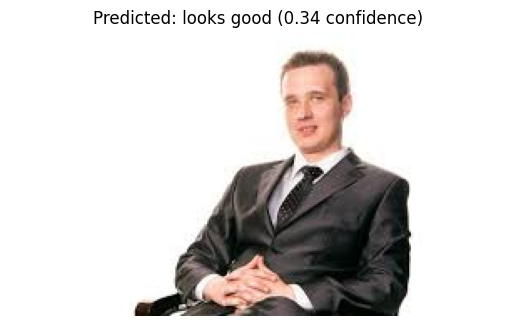

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Define classes for the posture dataset
classes = ["looks good", "sit up straight", "straighten head"]

# Function to preprocess the image
def preprocess_image_opencv(image_path, img_size=(224, 224)):
    img = cv2.imread(image_path)  # Load the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    img = cv2.resize(img, img_size)  # Resize the image to the model's input size
    img = img / 255.0  # Normalize the image to range [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = np.transpose(img, (0, 3, 1, 2))  # Change dimensions to (batch, channels, height, width)
    img = torch.tensor(img, dtype=torch.float32)  # Convert to tensor
    return img

# Function to classify the image using the model
def classify_posture_opencv(image_path, model, device):
    preprocessed_image = preprocess_image_opencv(image_path)
    preprocessed_image = preprocessed_image.to(device)  # Move to the same device as model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients during inference
        predictions = model(preprocessed_image)  # Get predictions
    predicted_class_index = torch.argmax(predictions, dim=1).item()  # Get the class with the highest probability
    confidence = torch.softmax(predictions, dim=1)[0][predicted_class_index].item()  # Get the confidence score
    predicted_class = classes[predicted_class_index]
    return predicted_class, confidence

# Test the model with an image
image_path = 'img3.jpeg'  # Path to your test image
device = torch.device("cpu")  # Make sure to use the CPU device
posture_model.to(device)  # Move the model to the same device

predicted_class, confidence = classify_posture_opencv(image_path, posture_model, device)

# Display the result
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Predicted: {predicted_class} ({confidence:.2f} confidence)")
plt.show()
